# PROJECT

This project is the final project of the academic course "Introduction to Machine Learning" (year 2024-2025).

The aim of the project is to develop a new type of learnable (parameterized in a way that backpropagation can optimize it) pooler (Pooling Operation, eg MaxPool2d) for standard CNN architecture.

The project is divided in 3 different parts:
1. Literature review and existing poolers implementation in PyTorch
2. Implementation of a new pooler in PyTorch
3. Evaluation of the new pooler on CIFAR10, CIFAR100 and MNIST using a standard CNN

The code will be develop in Python files, this notebook is the wrapper for the final product.

Author : *Francesco Bredariol SM3201379*

In [19]:
from models import *
from poolers import *
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

## PART 1
---
*Implementing existing pooling operators.*

### **Literature Review**

MaxPooling and AvgPooling are the default poolers in the majority of cases, mostly because they are easy to implement, fast at training and at inference, really intuitive and perform state of the art on traditional datasets as CIFAR10, CIFAR100 and MNIST. It also to be said that, a rule of thumb, should always be "keep it simple" (if possible) and those two poolers just fit perfectly. By the way researchers started to notice that sometimes they can be not enough, and a lot of time they cut out important information during the downsampling phase. In addiction they are static, meaning that they can not learn any parameter to improve their performance. Given this in mind researchers developed others poolers, some of them being differentiable and learnable, some of them being static but clever.

In order to obtain more information about existing and novels poolers I searched on the literature and ended up with two main papers. The first one is *"A Comparison of Pooling Methods for Convolutional Neural Networks"* (Zafar et al. 2022) while the second one is *"Generalizing Pooling Functions in CNNs: Mixed, Gated, and Tree"* (Lee et al. 2017). 

After studying them I decided to develop 4 different poolers:

1. MixingPooling2d, a simple pooler that combines MaxPooling2d and AvgPooling2d with a learnable parameter (semi-static)
2. GatedPooling2d, a pooler that combines MaxPooling2d and AvgPooling2s with a learnable gate (dynamic)
3. StochasticPooling2d, a pooler that try to reduce overfitting introducing stochasticity inside the dunamic of pooling (static but stochastic)
4. SP3Pooling2d, a novel pooler that aim to optimize the learning process introducing "inner augmentation" (static but stochastic)

For MixingPooling2d and GatedPooling2d there were no need to find additional material. For StochasticPooling2d I retrieved its original paper *"Stochastic Pooling for Regularization of Deep Convolutional Neural Networks"* (Zeiler & Fergus, 2013) and the same for SP3Pooling2d *"S3Pool: Pooling with Stochastic Spatial Sampling"* (Zhai et al. 2017).

### **MixingPooling2d**

Given a pooling patch $R_j$, the output of the pooling function $S_j$ is

$$
    S_j = \lambda \max(a_i) + (1 - \lambda)\frac{1}{|R_j|}\sum_{i\in R_j}a_i
$$

In order to keep $\lambda$ between 0 and 1, a sigmoid activation function is always applied to it, and in the end the equation can be rewritten as

$$
    S_j = \sigma(\lambda) \max(a_i) + (1 - \sigma(\lambda))\frac{1}{|R_j|}\sum_{i\in R_j}a_i
$$

where $\sigma$ stands for the sigmoid function.

$\lambda$ is shared between all the patches in a channel.

Results on how the backpropagation works are presented in the papers.

In [2]:
m = torch.tensor([[[[1., 2., 3., 4.], [5., 6., 7., 8.], [9., 10., 11., 12.], [13., 14., 15., 16.]]]])
print(m)
pooler = MixingPooling2d(2, 2, 1)
print(pooler.get_core()) # This is set to 0 as default, in order to obtain a 0.5 mixing factor at the beginning
print(pooler.forward(m))

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([0.5000], grad_fn=<SigmoidBackward0>)
tensor([[[[ 4.7500,  6.7500],
          [12.7500, 14.7500]]]], grad_fn=<AddBackward0>)


### **GatedPooling2d**

Given a pooling patch $R_j$, the output of the pooling function $S_j$ is

$$
    S_j = \sigma(\omega^TR_j) \max(a_i) + (1 -\sigma(\omega^TR_j))\frac{1}{|R_j|}\sum_{i\in R_j}a_i
$$

where $\sigma$ stands for the sigmoid function.

The GatedPooling2d learn different weights for every part of the pooling patch and thanks to that can be more adaptive and dynamic than the MixingPooling2d. Those weights are called gating masks, since they can actually be learned by a convolutional mask applied on the pooling patch.

While learning gating masks one has several options (listed in order of increasing number of parameters): learning one gating mask (a) per net, (b) per layer, (c) per layer/region being pooled (but used for all channels across that region), (d) per layer/channel (but used for all regions in each channel) (e) per layer/region/channel combination.

My implementation is the (e). 

Results on how the backpropagation works are presented in the papers.


In [3]:
m = torch.tensor([[[[1., 2., 3., 4.], [5., 6., 7., 8.], [9., 10., 11., 12.], [13., 14., 15., 16.]]]])
print(m)
pooler = GatedPooling2d(2, 2, 1)
print(pooler.get_core())
print(pooler.forward(m))

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
Parameter containing:
tensor([[[[ 0.4352, -0.2040],
          [-0.0061, -0.0322]]]], requires_grad=True)
tensor([[[[ 4.7295,  6.9684],
          [13.5480, 15.6738]]]], grad_fn=<AddBackward0>)


### **StochasticPooling2d**

Given a pooling patch $R_j$ we define a probability distribution on its indexes $\pi(R_j)$.

In the paper they use 

$$
    p_i = \frac{a_i}{\sum_{k \in R_j}a_k}
$$

Once $\pi(\cdot)$ is defined the output of the pooling function is

$$
    s_j = a_l \text{ where } l \sim Mult(1, \pi(R_j))
$$

In short, activations are selected based on probabilities and further calculated by multinomial distribution.

In my implementation I also developed $\pi(\cdot)$ as the softmax function and as the log_softmax function.

This pooler has no learnable parameters.

Results on how backpropagation works are presented in the papers.

In [4]:
m = torch.tensor([[[[1., 2., 3., 4.], [5., 6., 7., 8.], [9., 10., 11., 12.], [13., 14., 15., 16.]]]])
print(m)
pooler = StochasticPooling2d(2, 2, 1, mode = "softmax")
print(pooler.forward(m))
pooler = StochasticPooling2d(2, 2, 1, mode = "other")
print(pooler.forward(m))

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 6.,  3.],
          [14., 15.]]]])
tensor([[[[ 5.,  8.],
          [10., 15.]]]])


### **SP3Pooling2d**

SP3Pooling2d is the most novel poolers within the ones I implemented.

SP3Pooling is a stochastic, grid-based downsampling method that selects a subset of spatial locations from an input feature map using structured random sampling. As the StochasticPooling2d it has no learnable parameters.

It works as follows:

1. Perform a MaxPooling2d with no dimensionality reduction
2. Divide the input feature map into a grid of non-overlapping blocks (e.g., 4×4 patches)
3. Randomly sample a fixed number of rows and columns from each block (e.g., 2 out of 4)
4. Select the elements at the intersections of the sampled rows and columns
5. Repeat for each block, and combine all sampled patches into the downsampled output

Since the formulas behind this is a bit tedious, for further details I suggest to read the paper.

In [5]:
m = torch.tensor([[[[1., 2., 3., 4.], [5., 6., 7., 8.], [9., 10., 11., 12.], [13., 14., 15., 16.]]]])
print(m)
pooler = SP3Pooling2d(2, 2, 1, device="cpu")
print(pooler.forward(m))

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 6.,  8.],
          [10., 12.]]]])


## PART 2
---
*Developing a new learnable stochastic pooling operators.*

### **TDGSPooling2d**

TDGS stands for "Temperature Driven Gumbel SoftMax".\
In this novel pooling operator the idea is to let a learnable temperature parameter $\tau$ to model the Gumbel SoftMax (GSM).\
When $\tau$ is low (<1) the GSM produces sharpened distribution centered in the max value (similarly to a MaxPool) while when $\tau$$ is high (>1) the GSM produces softer distribution (similarly an uniform StochasticPool).\
The temperature parameter serves as balancer between deterministic behavior (which is somehow related to exploitation, MaxPool) and stochastic behavior (which is somehow related to exploration, Uniform StochasticPool).\
Developing a parameter per pooling patch (no temperature is shared) this can lead the architecture to learn specific spatial location where one strategy is better than the other.

##### **Main Problem**

What are the main challenges in developing this pooling function?\
We want to sample from a distribution parameterized by the parameter $\tau$.\
The main problem is that it is not feasible to optimize the parameter of a probability distribution while sampling from it using backpropagation: it is non-differentiable.

So, before diving in the solution, following this [tutorial](https://sassafras13.github.io/GumbelSoftmax/), let's dive in to some important aspects.

##### **Reparameterization trick**

Keep it simple: if we want to perform sampling and optimization from a gaussian, $z \sim N(\mu, \sigma^2)$, how can we do?\
Well, short story short, math comes in help and rememeber us that 
$$
    z = \mu + \sigma*\epsilon \text{ where } \epsilon \sim N(0, 1)
$$
This is perfect since now we can separate the deterministim (differentiable) from the stochasticity (non-differentiable). Visually this is what is happening:
[reparameterization](/imgs/reparameterizationtrick.png)

##### **Gumbel SoftMax**

Our problem now is that we want to sample from a categorical distribution. How to achieve this? We do this by computing the log probabilities of all the classes in the distribution (deterministic) and adding them to some noise (stochastic) from a Gumbel distribution. Once we have combined the two parts we can compute the SoftMax, which is full differentiable, even adding a learnable temperature parameter. In my developement I computed the log probabilites of the input divided by the learnable temperature parameter since I found it more effective. Visually this is what is happening:
[gumbelsoftmax](/imgs/gumbelsoftmax.png)

A mathematical proof of why this actually works can be seen [here](https://lips.cs.princeton.edu/the-gumbel-max-trick-for-discrete-distributions/). 

##### **Bringing all together**

One must notice that in order to obtain the desired behavior from this pooling technique something is missing: now we have a "softmax" as ouput, but we want just a raw single value, and we do not want to use a weighted sum. Luckily the Pytorch [implementation](https://docs.pytorch.org/docs/stable/generated/torch.nn.functional.gumbel_softmax.html) provides a "hard" return mode. If True, the returned samples will be discretized as one-hot vectors, but will be differentiated as if it is the soft sample in autograd. Using the one-hot vector now we can actually use the weighted sum as output, since it will just be the desired sampled value.\
And this is "it".

Some little adjustments are also implemented.

1. The temperature used while computing the log probabilities is not the raw temperature but a rectified one, to make it strictly positive
2. A little epsilon is also added to the rectified temperature in order to prevent numerical errors
3. Temperature is initialized from an Uniform distribution in $[0.5, 1.5]$ multiplied by an initial value
4. During inference a weighted sum is performed as output (related to what done in StochasticPooling)

##### **Last Adjustment**

Now we are dividing the logits by the temperature $t$ fixing $\tau$ to 1. This is a little "trick", because what we are actually doing is: 

1. If $t<1$ we are gonna increase the relevance of the maximum (and so the noise added by the Gumbell(0, 1) impacts more)
2. If $t>1$ we are gonna decrease the relevance of the maximum (and so the noise added by the Gumbell(0, 1) impacts less)

This is great but $t$ has an asymmetric impact: we need a decrease in its value of only 0.9 (from 1 to 0.1) to obtain a "full max" behavior, while we nedd an increase in its value of 9 (from 1 to 10) to obtain a "full uniform" behavior, and this is the lower bound considering elements of the same magnitude.

For now, to try to obtain elements always of the same magnitude, we are gonna normalize the vector before dividing it by the temperatures. This should not change the sensibility of the impact of $t$, but should help the overall sensibility.

Setting the initial value is pretty important. Choosing 0 or 10 is usually a bad choice since they are bot too extreme. The initial value set to 1 should be fine, since it is close enough to zero but not to cloose to impose all the $t$ to become 0 (letting some stochasticity).

After this adjustment think change pretty well, improving performances.

In [6]:
m = torch.tensor([[[[1., 2., 3., 4.], [5., 6., 7., 8.], [9., 10., 11., 12.], [13., 14., 15., 16.]]]]).to("cuda")
print(m)
pooler = TDGSPooling2d(2, 2, 1, "cuda", 2, 2, initial_value=0)
print(pooler.forward(m))

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]], device='cuda:0')
tensor([[[[ 6.,  8.],
          [14., 16.]]]], device='cuda:0', grad_fn=<ViewBackward0>)


## PART 3
---
*Evaluating pooling operators.*

For the evaluation part a simple CNN with 3 convolution layer is being developed.\
Each convolution layer is followed by a ReLU and by a pooler.\
The tail of the model is just two fully connected layers activated by ReLU.\
For the evaluation criterion CrossEntropy is used and I choose Adam as optimizer.\
I developed one architecture that uses MaxPooler and one that uses TDGSPooler.\
In order to evaluate the model I decided to use MNIST and cifar10 as datasets.

The evaluation part is divided in two parts:

1. Evaluating the model with TDGSPooler, studying the results in function of the temperature initial value
2. Comparising the best TDGS model with the MaxPool model

### EVALUATION

##### **MNIST**

MNIST (Modified National Institute of Standards and Technology) is one of the most iconic benchmark datasets in computer vision.

**Content**: 70,000 grayscale images of handwritten digits (0–9)

**Training set**: 60,000 images

**Test set**: 10,000 images

**Image size**: 28×28 pixels

**Color channels**: 1 (grayscale)

**Labels**: 10 classes (digits 0 through 9)

**Format**: Each image is a small centered digit, normalized in size and positioned in the image center.

In [7]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()

cuda


In [ ]:
initial_values = [0.5, 1, 1.5, 2, 3]
colors = ['k', 'b', 'g', 'r', 'y']
containers = []
performances = []
for i, i_v in enumerate(initial_values):
    model = TDSGSimpleCNN(dataset="MNIST", initial_value=i_v).to(device)
    print(f"TRAINING PHASE OF {model.name()} ...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = training(train_loader, model, device, criterion, optimizer, epochs=25, verbose = False)
    accuracy = testing(test_loader, model, device)
    containers.append([history, model.name(), colors[i]])
    performances.append(accuracy)

TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 0.5 ...
Test Accuracy: 99.26%
ACCURACY : 99.26%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 1 ...
Test Accuracy: 99.41%
ACCURACY : 99.41%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 1.5 ...
Test Accuracy: 99.30%
ACCURACY : 99.3%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 2 ...
Test Accuracy: 99.34%
ACCURACY : 99.34%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 3 ...
Test Accuracy: 99.14%
ACCURACY : 99.14%


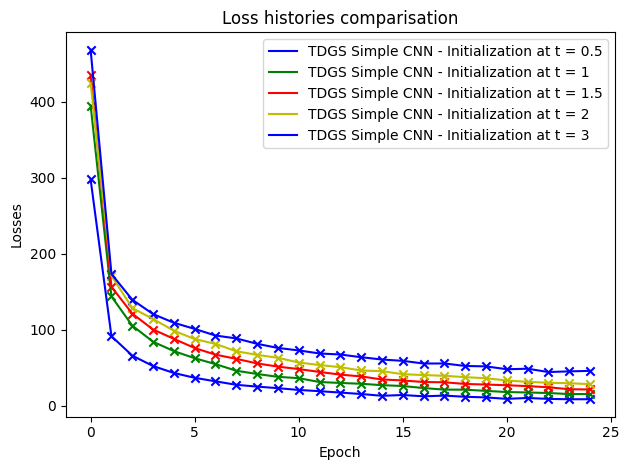

In [12]:
comparison_plot(containers)

In [34]:
performances_plot(initial_values, performances, "MNIST")

NameError: name 'performances_plot' is not defined

##### **CIFAR10**

CIFAR-10 (Canadian Institute For Advanced Research) is a more challenging dataset used to evaluate models on small-scale natural image classification.

**Content**: 60,000 color images of real-world objects, divided into 10 classes

**Training set**: 50,000 images

**Test set**: 10,000 images

**Image size**: 32×32 pixels

**Color channels**: 3 (RGB)

**Classes**: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

**Format**: Low-resolution color photos labeled into coarse semantic categories

In [14]:
transform = transforms.ToTensor()

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
criterion = nn.CrossEntropyLoss()

cuda


In [17]:
initial_values = [0.5, 1, 1.5, 2, 3]
colors = ['k', 'b', 'g', 'r', 'y']
containers = []
performances = []
for i, i_v in enumerate(initial_values):
    model = TDSGSimpleCNN(dataset="cifar10", initial_value=i_v).to(device)
    print(f"TRAINING PHASE OF {model.name()} ...")
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = training(train_loader, model, device, criterion, optimizer, epochs=25, verbose = False)
    accuracy = testing(test_loader, model, device)
    print(f"ACCURACY : {accuracy}%")
    containers.append([history, model.name(), colors[i]])
    performances.append(accuracy)

TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 0.5 ...
Test Accuracy: 71.55%
ACCURACY : 71.55%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 1 ...
Test Accuracy: 73.90%
ACCURACY : 73.9%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 1.5 ...
Test Accuracy: 72.06%
ACCURACY : 72.06%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 2 ...
Test Accuracy: 71.69%
ACCURACY : 71.69%
TRAINING PHASE OF TDGS Simple CNN - Initialization at t = 3 ...
Test Accuracy: 69.25%
ACCURACY : 69.25%


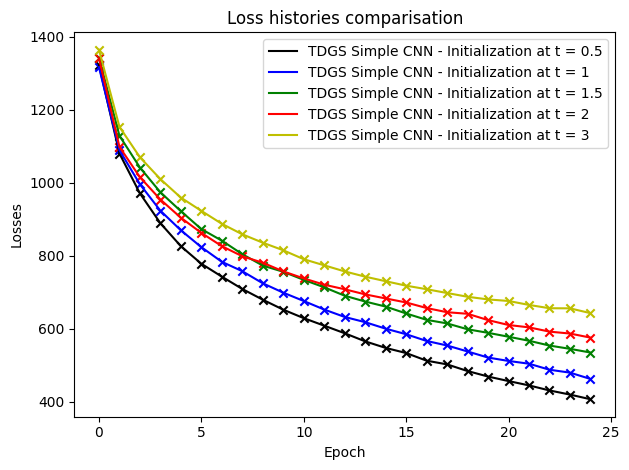

In [18]:
comparison_plot(containers)

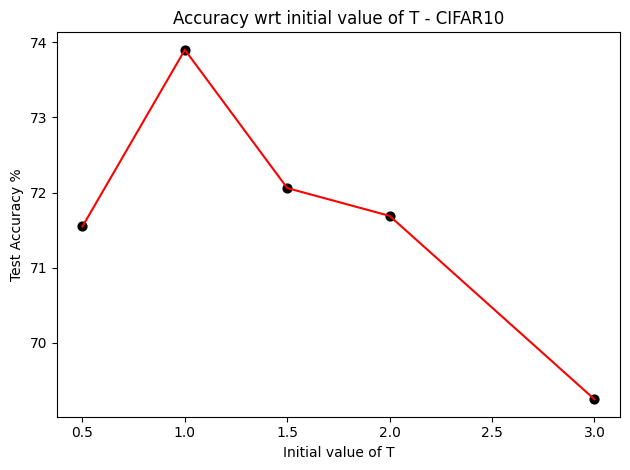

In [33]:
plt.plot(initial_values, performances, color = 'r')
plt.scatter(initial_values, performances, marker='o', color = 'k', s = 40)
plt.title("Accuracy wrt initial value of T - CIFAR10")
plt.xlabel("Initial value of T")
plt.ylabel("Test Accuracy %")
plt.tight_layout()
plt.show()

##### **Observation**

The results are really interesting. Altough the better training curve is the one produced by the smallest initial values of t, we can clearly see, in both cases, how the initial value 1 is the best one (in the second case by a far margin). In my opinion this is because, how said in the beginning, 1 is a good tradeoff point between 0 and 10, which are the two extremes for the pooler behavior.

### COMPARISON

-> TO PLOT : risultati simplecnn mnist e cifar10 (con evaluation history) contro risultati tdgssimplecnn mnist e cifar10\
-> TO PLOT : risultati tdgssimple cnn mnist e cifar10 (con evaluation history) in base al valore iniziale\
-> mettere gli snippet di codice per raccogliere i dati (che sono messi su una cartella a parte "results" generata da model.py) e per plottarli